In [7]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
from scipy.integrate import quad 
from numpy.polynomial import Polynomial
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from IPython.display import display
import ipywidgets as widgets
import os
from ipywidgets import interact, IntSlider, Button, VBox, Output
from scipy import constants as const

In [8]:
# Leer el archivo CSV con separador y decimal correctos
df = pd.read_csv('Alfa_Boo_pepsi.csv', delim_whitespace=True)

wavelength = df['Wavelength'].values

flux = df['Normalised_Flux'].values


C:\Users\Jessi Dani\AppData\Local\Temp\ipykernel_1768\1429585468.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('Alfa_Boo_pepsi.csv', delim_whitespace=True)


In [31]:
df_hierro = pd.read_excel('lineas_teoricas_hierro1.xlsx')

fe_1_lineas = df_hierro[0]
fe_1_lineas = fe_1_lineas.dropna().values

In [32]:
fe_1_lineas

array([3940.8776, 3941.2753, 3946.9949, 3948.0973, 4000.4572, 4001.6617,
       4006.3108, 4011.4075, 4029.6293, 4031.9607, 4059.7135, 4073.7623,
       4080.2092, 4084.4915, 4085.0041, 4087.0939, 4089.2169, 4100.7379,
       4101.2611, 4104.1136, 4106.4229, 4109.0561, 4120.2065, 4121.8026,
       4122.5155, 4125.8804, 4126.1827, 4132.8992, 4136.9977, 4139.9273,
       4146.0642, 4147.669 , 4150.2491, 4154.4987, 4154.8055, 4157.7801,
       4158.7924, 4175.6361, 4176.5659, 4182.3826, 4184.8918, 4187.039 ,
       4187.7954, 4195.3291, 4196.2083, 4199.9835, 4202.753 , 4203.5678,
       4205.5385, 4207.1271, 4208.604 , 4213.6474, 4220.3417, 4222.2131,
       4224.1717, 4224.5128, 4229.7516, 4232.7263, 4233.6028, 4238.0238,
       4238.81  , 4258.3158, 4258.9517, 4264.2034, 4266.9645, 4267.8265,
       4282.4029, 4285.442 , 4288.1458, 4291.4637, 4294.1248, 4298.0364,
       4304.5408, 4326.7533, 4327.0956, 4327.9034, 4337.0463, 4343.6975,
       4346.5526, 4348.9366, 4351.5439, 4358.4991, 

In [34]:
z_max = 2e-5

resolucion = np.mean(np.diff(wavelength))
separacion_minima = np.min(np.diff(fe_1_lineas))
distancia = int(np.ceil(separacion_minima/resolucion))

def encontrar_lambda_teorica(centro):
    diferencias = np.abs(fe_1_lineas - centro)
    tolerancias = z_max * fe_1_lineas + resolucion
    idx = np.argmin(diferencias)  
    if diferencias[idx] <= tolerancias[idx]:
        return fe_1_lineas[idx]
    else:
        return None

In [38]:
inv_flux = 1 - flux
picos, _ = find_peaks(
    inv_flux,
    prominence=0.03,       
    distance=distancia,          
                   
)

picos_filtrados = []
for pico in picos:
    lambda_pico = wavelength[pico]
    lambda_teorica = encontrar_lambda_teorica(lambda_pico)
    if lambda_teorica is not None:
        picos_filtrados.append(pico)


ventana = 5
centros_interpolados = []
polinomios = []
area_polinomio_interpolador = []
profundidad_real = []

for pico in picos:
    if pico - ventana < 0 or pico + ventana >= len(wavelength):
        continue
    
    x = wavelength[pico - ventana:pico + ventana + 1]
    y = flux[pico - ventana:pico + ventana + 1]
    
   
    x_centro = x.mean()
    x_reubicado = x - x_centro

    
    coef = np.polyfit(x_reubicado, y, deg=4)
    p = Polynomial(coef[::-1])

 
    def polinomio_recentrado(lmbda):
        return p(lmbda - x_centro)

   
    area_polinomio, _ = quad(polinomio_recentrado, x[0], x[-1])
    area_polinomio_interpolador.append(area_polinomio)

    """
    profundidad_equivalente = (x[-1] - x[0]) - area_polinomio
    profundidad_real.append(profundidad_equivalente)

    """


    dp = p.deriv()
    raices = dp.roots()
    raices_reales = raices[np.isreal(raices)].real
    raices_en_intervalo = [r for r in raices_reales if x_reubicado.min() <= r <= x_reubicado.max()]
    
    if raices_en_intervalo:
        minimo_reubicado = raices_en_intervalo[np.argmin(p(raices_en_intervalo))]
        minimo = minimo_reubicado + x_centro   
        centros_interpolados.append(minimo)
        polinomios.append((p, x_centro))   


print(f"Total de picos detectados: {len(picos)}")

Total de picos detectados: 8569


In [39]:
os.makedirs("graficas_lineas", exist_ok=True)

calculo_z = []
calculo_v = []
calculo_lambda = []
calculo_area = []
coeficiente_0 = []
coeficiente_1 = []
coeficiente_2 = []
coeficiente_3 = []
coeficiente_4 = []
flujo_centro_lista = []
#f1_lista = []
#f2_lista = []
#f3_lista = []
profundidad_grafica = []
curvaturas = []
bisectrices = []

centro_filtrado = []
profundidad_filtrada_l = []

const.c

for i, (centro, (p, x_centro)) in enumerate(zip(centros_interpolados, polinomios)):

    lambda_teorica = encontrar_lambda_teorica(centro)
    if lambda_teorica is None:
        continue

    z = (centro - lambda_teorica) / lambda_teorica
    v = z * const.c

    if not (-1500 <= v <= 1500):
        print(f"v = {v:.4f} km/s fuera de rango para λ_obs = {centro:.4f}, λ_teo = {lambda_teorica:.4f}")
        continue


    centro_filtrado.append(centro)
    calculo_z.append(z)
    calculo_v.append(v)
    calculo_lambda.append(lambda_teorica)

    """
    profundidad_filtrada_l.append(profundidad_real[i])
    """

    indice_cercano = np.argmin(np.abs(wavelength - centro))
    if indice_cercano - ventana < 0 or indice_cercano + ventana >= len(wavelength):
        continue

    x = wavelength[indice_cercano - ventana: indice_cercano + ventana + 1]
    y = flux[indice_cercano - ventana: indice_cercano + ventana + 1]

    delta_lambda = np.diff(x)  
    altura_promedio = 1 - y[1:]
    area = np.sum(altura_promedio * delta_lambda) 

    calculo_area.append(area)



    x_fina = np.linspace(x[0], x[-1], 200)
    y_fina = p(x_fina - x_centro)

    flujo = p(centro-x_centro)
    flujo_centro_lista.append(flujo) 
    coef = p.coef

    ecuacion = r"$P(X) = {:.3e} + {:.3e}x + {:.3e}x^2 + {:.3e}x^3 + {:.3e}x^4$".format(
        coef[0], coef[1], coef[2], coef[3], coef[4])

    coeficiente_0.append(coef[0])
    coeficiente_1.append(coef[1])
    coeficiente_2.append(coef[2])
    coeficiente_3.append(coef[3])
    coeficiente_4.append(coef[4])

    flujo_f_1 = p.deriv(1)(centro-x_centro)
    #f1_lista.append(flujo_f_1)

    flujo_f_2 = p.deriv(2)(centro-x_centro)
    #f2_lista.append(flujo_f_2)
    
    flujo_f_3 = p.deriv(3)(centro-x_centro)
    #f3_lista.append(flujo_f_3)

    profundidad_flujo = 1 - flujo
    profundidad_grafica.append(profundidad_flujo)

    #Curvatura

    # Core curvature (segunda derivada corregida por λ_obs²)
    curvatura = flujo_f_2 * (centro**2)
    curvaturas.append(curvatura)

    #Cálculo Bisectriz
    def calculo_bisectriz(second, third):
        return (-1)*((third) / (3 * (second**2))) * (const.c / centro)
    
    bisectriz = calculo_bisectriz(flujo_f_2,flujo_f_3)*(centro**3)
    bisectrices.append(bisectriz)
    

    leyenda = (f"Área = {area:.5f} Å\n"
               f"Coeficientes: \n {ecuacion} \n"
               f"Profundidad: = {profundidad_flujo:.4f} \n")
    
    plt.figure(figsize=(14, 7))
    plt.plot(x, y, label="Espectro")
    plt.plot(x_fina, y_fina, 'yellow', label="Interpolación polinómica")
    plt.fill_between(x, y, 1, color='pink', alpha=0.4, label=leyenda)
    plt.axvline(centro, color='purple', linestyle='--', lw=1, label="Centro interpolado")
    if lambda_teorica:
        plt.axvline(lambda_teorica, color='red', linestyle=':', lw=1, label="Línea teórica")
    plt.title(f"λ_obs (Å) = {centro:.4f}; z = {z:.3e}; v = {v:.3g} [km/s]")
    plt.xlabel("Longitud de onda [Å]")
    plt.ylabel("Flujo normalizado")
    plt.legend()
    plt.tight_layout()

    nombre_archivo = f"graficas_lineas/linea_{centro:.4f}.png"
    plt.savefig(nombre_archivo)
    plt.close()

#Aunque no se utiliza explicitamente f1 y f2 el primero sirvió para verificar que todos los centros interpolados fueran mínimos.El segundo sirvió para verificar la curvatura de estos mínimos por lo cual todos son positivos.

v = 1505.1381 km/s fuera de rango para λ_obs = 4466.5742, λ_teo = 4466.5518
v = 2041.8318 km/s fuera de rango para λ_obs = 4942.4929, λ_teo = 4942.4592


In [ ]:
df_resultados = pd.DataFrame({ 
    "λ_teo (Å)": calculo_lambda,
    "λ_obs (Å)": centro_filtrado,
    "Flujo": flujo_centro_lista,
    "Profundidad": profundidad_grafica,
    "Velocidad (km/s)": calculo_v,
    "Curvatura": curvaturas,
    "Bisectriz":bisectrices,
    "Coef 0": coeficiente_0,
    "Coef 1": coeficiente_1,
    "Coef 2": coeficiente_2,
    "Coef 3": coeficiente_3,
    "Coef 4": coeficiente_4
})

# Guardar CSV
df_resultados.to_csv("resultados_lineas.csv", index=False, encoding='utf-8')
print("CSV guardado como resultados_lineas.csv")

CSV guardado como resultados_lineas.csv


In [ ]:
df = pd.read_csv("resultados_lineas.csv", encoding='utf-8')

def mostrar_resultados(start=0, n=10):
    display(df.iloc[start:start+n].style.format({
        "λ_teo (Å)": "{:.4f}",
        "λ_obs (Å)": "{:.4f}",
        "Flujo": "{:.4f}",
        "Profundidad": "{:.4f}",
        "Velocidad (km/s)": "{:.3e}",
        "Curvatura": "{:.3e}",
        "Bisectriz": "{:.3e}",
        "Coef 0": "{:.3e}",
        "Coef 1": "{:.3e}",
        "Coef 2": "{:.3e}",
        "Coef 3": "{:.3e}",
        "Coef 4": "{:.3e}"
    }))

# Widgets para controlar inicio y cantidad de filas
start_slider = widgets.IntSlider(value=0, min=0, max=len(df)-1, step=1, description='Start:')
n_slider = widgets.IntSlider(value=10, min=1, max=len(df), step=1, description='Rows:')

# Mostrar tabla interactiva
widgets.interactive(mostrar_resultados, start=start_slider, n=n_slider)

interactive(children=(IntSlider(value=0, description='Start:', max=476), IntSlider(value=10, description='Rows…

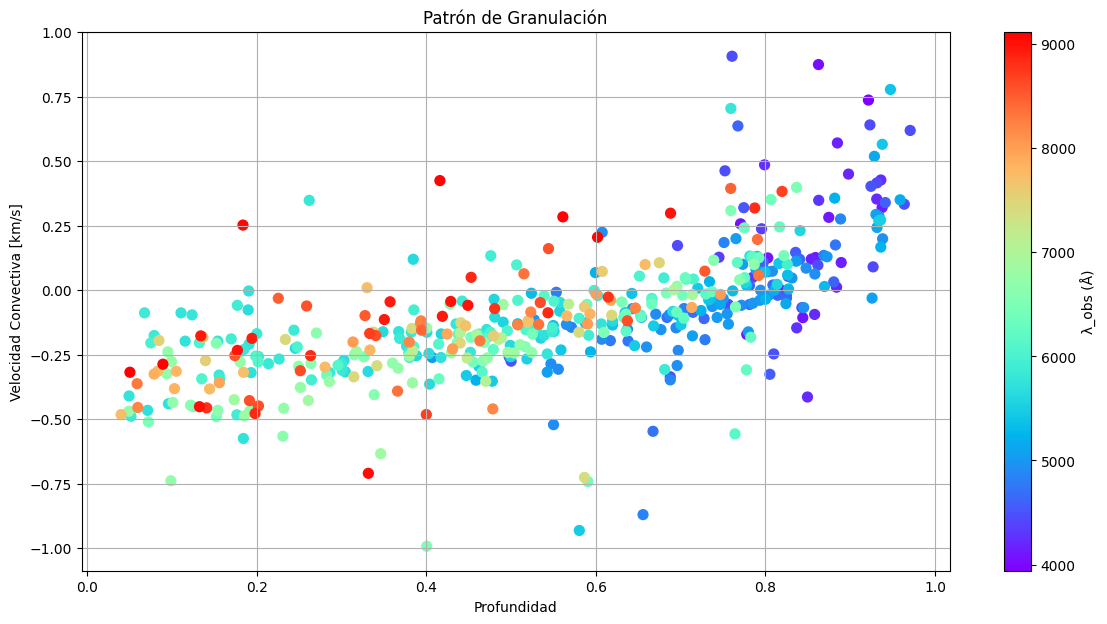

In [ ]:
plt.figure(figsize=(14, 7))

sc = plt.scatter(
    df_resultados['Profundidad'],
    df_resultados['Velocidad (km/s)'],
    c=df_resultados['λ_obs (Å)'],  
    cmap='rainbow',                  
    s=50
)

plt.xlabel("Profundidad")
plt.ylabel("Velocidad Convectiva [km/s]")
plt.title("Patrón de Granulación")
plt.grid(True)

# Añadir barra de color
cbar = plt.colorbar(sc)
cbar.set_label("λ_obs (Å)")

plt.show()

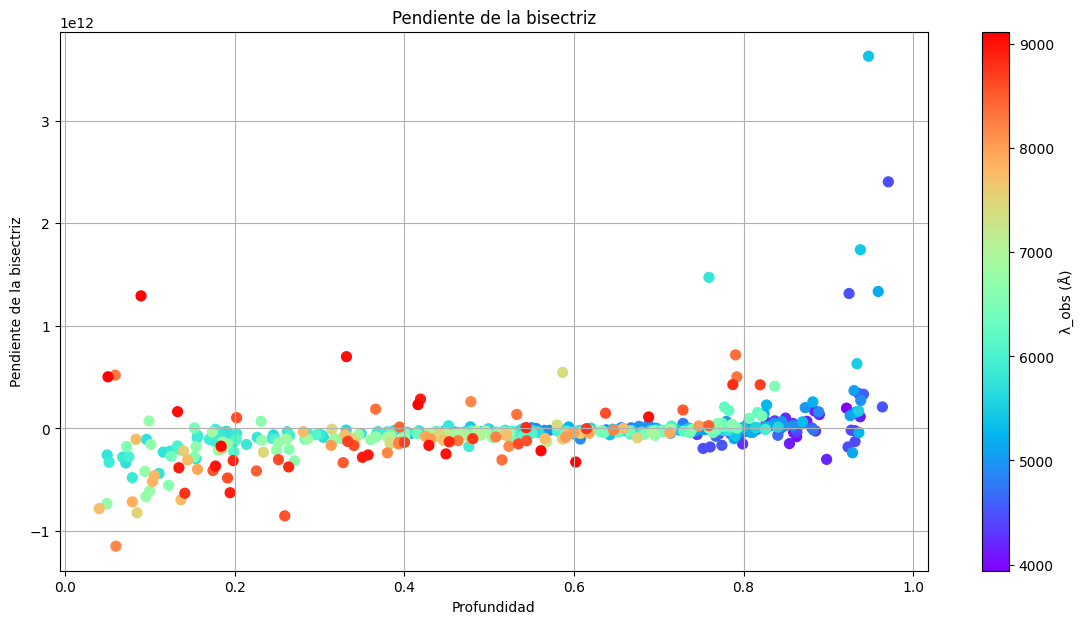

In [ ]:
plt.figure(figsize=(14, 7))

sc = plt.scatter(
    df_resultados['Profundidad'],
    df_resultados['Bisectriz'],
    c=df_resultados['λ_obs (Å)'],  
    cmap='rainbow',                  
    s=50
)

plt.xlabel("Profundidad")
plt.ylabel("Pendiente de la bisectriz")
plt.title("Pendiente de la bisectriz")
plt.grid(True)

# Añadir barra de color
cbar = plt.colorbar(sc)
cbar.set_label("λ_obs (Å)")

plt.show()

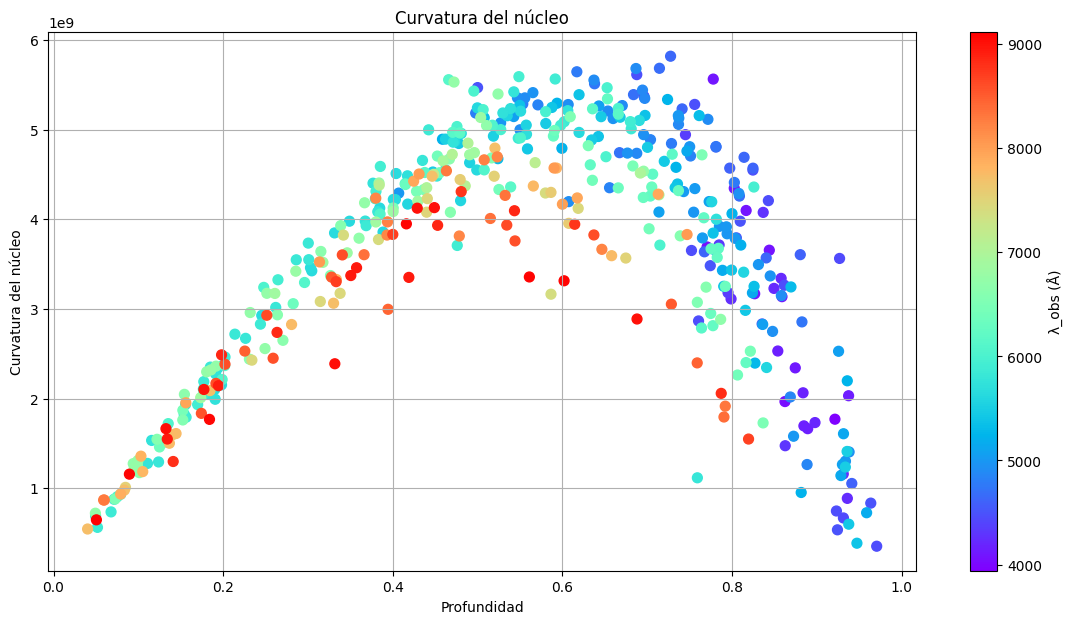

In [ ]:
plt.figure(figsize=(14, 7))

sc = plt.scatter(
    df_resultados['Profundidad'],
    df_resultados['Curvatura'],
    c=df_resultados['λ_obs (Å)'],  
    cmap='rainbow',                  
    s=50
)

plt.xlabel("Profundidad")
plt.ylabel("Curvatura del núcleo")
plt.title("Curvatura del núcleo")
plt.grid(True)

# Añadir barra de color
cbar = plt.colorbar(sc)
cbar.set_label("λ_obs (Å)")

plt.show()